<a href="https://colab.research.google.com/github/LauraBreton-leonard/PRD/blob/main/MultipleInputModleLaura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [241]:
# https://realpython.com/python-keras-text-classification/

%tensorflow_version 2.x  # this line is not required unless you are in a notebook
%load_ext tensorboard
!pip install keras --upgrade
!pip install pickle5
from keras.preprocessing import sequence
import keras
from keras.layers import Input, Dense, LSTM, Embedding, Bidirectional,Concatenate, concatenate, Flatten,GlobalAveragePooling1D, SpatialDropout1D
from tensorflow.keras import regularizers
from keras.models import Sequential,Model
from keras import layers
import tensorflow as tf
import os
import numpy as np
import sklearn as sk
import pandas as pd

from sklearn.model_selection import train_test_split
import pickle5 as pickle

import datetime


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


       geo1  geo2  geo3  ...  geo8                            sentences  labels
0        72    25   326  ...    64                        TAN WOON YANN       0
1        50    82   440  ...   121      BOOK TA .K (TAMAN DAYA) SDN BND       3
2       205   121   285  ...   139                             789417-W       0
3       110   144   383  ...   163     NO.53 55,57 & 59, JALAN SAGU 18,       2
4       192   169   299  ...   187                          TAMAN DAYA,       2
...     ...   ...   ...  ...   ...                                  ...     ...
33563   124   772   170  ...   790                                TOTAL       0
33564   318   773   366  ...   790                                11.32       0
33565   439   772   478  ...   789                                 0.68       0
33566   242   810   362  ...   828                            THANK YOU       0
33567   159   837   461  ...   853  FOR ANY ENQUIRY, PLEASE CONTACT US:       0

[33568 rows x 10 columns]
0            

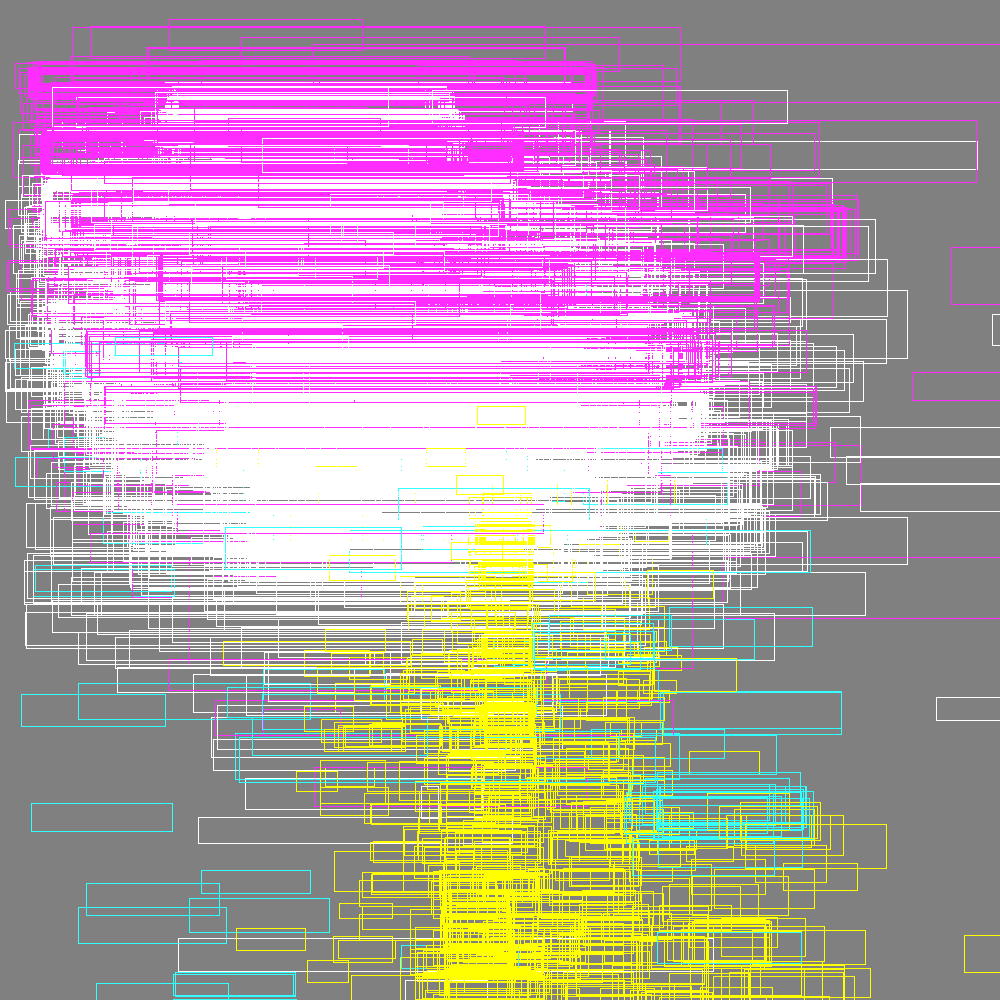

In [242]:
df = pd.read_hdf('/content/allData.h5')
df.dtypes
print(df)
X = df.iloc[:,:8].values
y = df.iloc[:,9:10].values

sentence=df['sentences']
print(sentence)
print(sentence.shape)
sentence = np.array(sentence, dtype = 'str')
sentence=sentence.tolist()
print(sentence[1])
#Visualsation des bbox pour chaque label ( on voit la tendance)
from PIL import Image, ImageDraw
im = Image.new('RGB', (1000,1000), (128, 128, 128))
draw = ImageDraw.Draw(im)
for i in range(0,len(y),1):
  if (y[i]==1):
    draw.line(((X[i][0], X[i][1]), (X[i][2], X[i][3]), (X[i][4], X[i][5]), (X[i][6], X[i][7]),(X[i][0], X[i][1])), fill=(255,255,0))
    
  if (y[i]==2):
    draw.line(((X[i][0], X[i][1]), (X[i][2], X[i][3]), (X[i][4], X[i][5]), (X[i][6], X[i][7]),(X[i][0], X[i][1])), fill=(255,255,255))
  if (y[i]==3):
    draw.line(((X[i][0], X[i][1]), (X[i][2], X[i][3]), (X[i][4], X[i][5]), (X[i][6], X[i][7]),(X[i][0], X[i][1])), fill=(255,45,255))
  if (y[i]==4):
    draw.line(((X[i][0], X[i][1]), (X[i][2], X[i][3]), (X[i][4], X[i][5]), (X[i][6], X[i][7]),(X[i][0], X[i][1])), fill=(50,255,255)) 
    
display(im)

#pas pertinent ici
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X = sc.fit_transform(X)

#codage binaire des labels
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

#splitting du dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test,sentence_train, sentence_test = train_test_split(X,y,sentence,test_size = 0.1)





In [243]:
MAXLEN = 250
BATCH_SIZE = 64

tokenizer

In [244]:
#tokenisation des phrases (tokenizer de keras), necessaire avant la couche d'embedding

#Creation tokenizer, oov token= True pour prendre en compte les mots inconnus
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=None,split=' ', filters='')
#le word_index est cree sur la bas du training set
tokenizer.fit_on_texts(sentence_train)
#tokenisation des dataset
tokens_from_train=tokenizer.texts_to_sequences(sentence_train)
tokens_from_test=tokenizer.texts_to_sequences(sentence_test)
#test
print(tokens_from_test)
text_from_token=tokenizer.sequences_to_texts(tokens_from_test) 
print(text_from_token)
VOCAB_SIZE=len(tokenizer.word_index)+1 #6631+1 pour le padding

[[175], [384], [1, 884, 514, 786], [4], [68], [6254, 33], [180], [204], [379, 1269, 1], [5527], [61], [1045], [2, 90, 54], [1326, 620, 1805], [274], [440], [10, 1357], [107, 144, 3], [7], [204], [306, 91], [2, 87], [2815], [2227], [61], [4], [470, 601, 1419], [142, 115, 4, 871, 424, 578], [], [260, 11, 290, 291, 104], [1285], [2, 112, 1], [], [1211, 3653], [4], [4093], [7613], [146, 157, 446, 209, 379], [12], [186], [96], [126, 20, 17], [6, 9], [], [362, 1242, 1522, 1], [3], [606, 649, 650, 695], [295], [28], [458, 795, 9279], [34, 439, 146, 48, 210, 762, 59, 146], [282], [5250, 375, 20, 17, 5251], [], [27], [8078], [213], [823], [11137], [405], [2], [775], [], [153, 1522], [27], [16, 1559], [], [43], [306, 91], [5], [], [2877, 431], [127], [3, 53, 309], [1], [120], [97], [2, 7], [7], [65, 1, 1256], [28], [568, 184], [28], [], [1130], [894, 37, 895], [8383, 23, 8385], [8, 1], [7], [408], [234, 59, 235, 236, 99, 59, 203], [10898], [16, 72, 29, 30, 102], [4513], [2, 2229, 1], [4, 2495, 7

padding

In [245]:
sentence_train_data_to_feed = sequence.pad_sequences(tokens_from_train, MAXLEN)
sentence_test_data_to_feed = sequence.pad_sequences(tokens_from_test, MAXLEN)
print(sentence_test_data_to_feed)
print(sentence_train_data_to_feed.dtype)

[[  0   0   0 ...   0   0 175]
 [  0   0   0 ...   0   0 384]
 [  0   0   0 ... 884 514 786]
 ...
 [  0   0   0 ...   0   0 730]
 [  0   0   0 ...   0 303   2]
 [  0   0   0 ...   0   0  25]]
int32


labels preprocess

coordinates preprocessing

Creation du model(multiple input)

In [246]:
"""
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 32),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
"""

"""Mon multi input model
nlp_input = Input(shape=(250,), name='nlp_input')
meta_input = Input(shape=(8,), name='meta_input')
emb = Embedding(output_dim=128, input_dim=VOCAB_SIZE, input_length=MAXLEN)(nlp_input)
nlp_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)
x = layers.concatenate([nlp_out, meta_input])
#x = Dense(1, activation='relu')(x)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=[nlp_input , meta_input], outputs=[x])

inputA = Input(shape=(26854,))
inputB = Input(shape=(26854,))

x = Dense(8, activation="relu")(inputA)
x = Dense(4, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)

y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(4, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)

combined = concatenate([x.output, y.output])


z = Dense(2, activation="relu")(combined)
z = Dense(5, activation="softmax")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)
"""



import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(16, input_dim=8, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(5, activation='softmax'))

model2 = Sequential()
model2.add(Embedding(output_dim=16, input_dim=VOCAB_SIZE, input_length=MAXLEN))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(5, activation='softmax'))


#multiInput model!!!
nlp_input = Input(shape=(250,), name='nlp_input')
meta_input = Input(shape=(8,), name='meta_input')
emb = Embedding(output_dim=128, input_dim=VOCAB_SIZE, input_length=MAXLEN)(nlp_input)
nlp_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)

x = layers.concatenate([nlp_out, meta_input])
x = Dense(12, activation='relu')(x)
x = Dense(5, activation='softmax')(x)
model4 = Model(inputs=[nlp_input , meta_input], outputs=[x])



In [257]:

nlp_input = Input(shape=(250,), name='nlp_input')
emb = Embedding(output_dim=16, input_dim=VOCAB_SIZE, input_length=MAXLEN)(nlp_input)
nlp_out = Bidirectional(LSTM(16, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)

meta_input = Input(shape=(8,), name='meta_input')

x = layers.concatenate([nlp_out, meta_input])
x = Dense(12, activation='relu')(x)
x = Dense(5, activation='softmax')(x)
model4 = Model(inputs=[nlp_input , meta_input], outputs=[x])
model4.summary()

model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



history = model4.fit([sentence_train_data_to_feed,X_train], y_train, epochs=2, batch_size=64, validation_split=0.2)


Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 250, 16)      178928      nlp_input[0][0]                  
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 32)           4224        embedding_18[0][0]               
__________________________________________________________________________________________________
meta_input (InputLayer)         [(None, 8)]          0                                            
______________________________________________________________________________________

In [247]:
model2.summary()





Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 250, 16)           178928    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 250, 16)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               46800     
_________________________________________________________________
dense_48 (Dense)             (None, 5)                 505       
Total params: 226,233
Trainable params: 226,233
Non-trainable params: 0
_________________________________________________________________


In [249]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



history = model2.fit(sentence_train_data_to_feed, y_train, epochs=50, batch_size=64, validation_split=0.2)
#history = model.fit(X_train, y_train, epochs=10, batch_size=64, )

Epoch 1/50
378/378 [==============================] - 202s 535ms/step - loss: 0.0833 - accuracy: 0.9707 - val_loss: 0.1542 - val_accuracy: 0.9598
Epoch 2/50
378/378 [==============================] - 201s 532ms/step - loss: 0.0771 - accuracy: 0.9719 - val_loss: 0.1504 - val_accuracy: 0.9591
Epoch 3/50
378/378 [==============================] - 209s 552ms/step - loss: 0.0705 - accuracy: 0.9724 - val_loss: 0.1526 - val_accuracy: 0.9603
Epoch 4/50
378/378 [==============================] - 201s 531ms/step - loss: 0.0665 - accuracy: 0.9733 - val_loss: 0.1727 - val_accuracy: 0.9431
Epoch 5/50
378/378 [==============================] - 206s 546ms/step - loss: 0.0606 - accuracy: 0.9734 - val_loss: 0.1616 - val_accuracy: 0.9583
Epoch 6/50
378/378 [==============================] - 216s 573ms/step - loss: 0.0566 - accuracy: 0.9756 - val_loss: 0.1986 - val_accuracy: 0.9067
Epoch 7/50
378/378 [==============================] - 218s 576ms/step - loss: 0.0528 - accuracy: 0.9764 - val_loss: 0.1742 -

In [265]:
y_pred = model4.predict([sentence_test_data_to_feed,X_test])
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()

for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

county=0
countn=0
countyneg=0
countneg=0
for i in range(0, len(test),1):
   
  if (test[i]!=0):
      if (pred[i]==test[i]):
        
        if (test[i]==3):
          print(sentence_test[i])
          print(test[i])
          print(pred[i])
          county=county+1
       
      else:
        countn=countn+1
  if (test[i]==0):
      if (pred[i]==test[i]):
     
        countyneg=countyneg+1
      elif (pred[i]!=test[i]):
        countneg=countneg+1    
print(len(test))     
print(countn)  
print(county)
print('acc=',((county*100)/(countn+county)),'%')  
print(countneg)  
print(countyneg)
print('acc0=',((countyneg*100)/(countneg+countyneg)),'%')  

CP. (M) SDN BHD
3
3
KEDAI PAPAN YEW CHUAN
3
3
MIZU MENTAI SDN. BHD. (1248446-V)
3
3
YONG CEN ENTERPRISE
3
3
BECON ENTERPRISE SDN BHD (82256-V)
3
3
MR. D.I.Y. (M) SDN BHD
3
3
RESTORAN WAN SHENG
3
3
SANYU STATIONERY SHOP
3
3
GL HANDICRAFT & TAIL ORING
3
3
MR. D.I.Y. (KUCHAI) SDN BHD
3
3
MR. D. I. Y. (KUCHAI) SDN BHD
3
3
SANYU STATIONERY SHOP
3
3
SYARIKAT PERNIAGAAN GIN KEE
3
3
CO. (M) SDN BHD
3
3
CO. (M) SDN BHD
3
3
LITTLE CRAVINGS SDN BHD (562007-D)
3
3
RESTAURANT SDN BHD
3
3
SYARIKAT PERNIAGAAN GIN KEE
3
3
POPULAR BOOK
3
3
THE TOAST F&B SDN BHD (965752-T)
3
3
LIGHTROOM GALLERY SDN BHD
3
3
SANYU STATIONERY SHOP
3
3
32 PUB & BISTRO OWN BY CNU TRADING
3
3
FAMILYMART
3
3
SUPER SEVEN CASH & CARRY SDN BHD
3
3
MR. D.I.Y. (M) SDN BHD
3
3
#000002 BAIFU (M) SDN BHD
3
3
3357
302
27
acc= 8.206686930091186 %
278
2674
acc0= 90.58265582655827 %


In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [ ]:
results = loss, main_loss, aux_loss, main_acc, aux_acc = model.evaluate(x={'main_input': sentence_test_data_to_feed, 'aux_input': geo_test},
                                y={'main_output': label_test, 'aux_output': label_test},
                                batch_size=BATCH_SIZE)
print(results)

In [ ]:
word_index = imdb.get_word_index()
print(word_index)

def encode_text(text):
  tokens = keras.preprocessing.text.text_to_word_sequence(text)
  tokens = [word_index[word] if word in word_index else 0 for word in tokens]
  return sequence.pad_sequences([tokens], MAXLEN)[0]

text = "that movie was just amazing, so amazing"
encoded = encode_text(text)
print(encoded)

In [ ]:
def predict(text):
  encoded_text = encode_text(text)
  pred = np.zeros((1,250))
  pred[0] = encoded_text
  result = model.predict(pred) 
  print(result[0])

positive_review = "That movie was! really loved it and would great watch it again because it was amazingly great"
predict(positive_review)

negative_review = "that movie really sucked. I hated it and wouldn't watch it again. Was one of the worst things I've ever watched"
predict(negative_review) 